Import some libraries
--

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from helper import *

Load the relevant simulation result data
--

In [2]:
label= "2021-07-22-runs/run"
gid= "0.0"
pop= "PNs"
N= 800
nglo= N//5
spike_t= np.load(label+"_hom_"+gid+"_"+pop+"_spike_t.npy")
spike_ID= np.load(label+"_hom_"+gid+"_"+pop+"_spike_ID.npy")
t_total= spike_t[-1]

In [3]:
mlabel= "2021-07-22-runs/run_hom_0.0_odors_0_1"
mspike_t= np.load(mlabel+"_"+pop+"_spike_t.npy")
mspike_ID= np.load(mlabel+"_"+pop+"_spike_ID.npy")
mt_total= mspike_t[-1]

In [7]:
odors= np.load("2021-07-22-runs/run_odors.npy")

Define a couple of extra helper functions
--
force_aspect to force the aspect ratio of imshow plots

glo_avg to take the average of data across all entities belonging to the same glomerulus/OR type

In [4]:
def force_aspect(ax,aspect):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [5]:
def glo_avg(sdf: np.ndarray, n):
    nglo= sdf.shape[1]//n
    gsdf= np.zeros((sdf.shape[0],nglo))
    for i in range(nglo):
        gsdf[:,i]= np.mean(sdf[:,n*i:n*(i+1)],axis=1)
    return gsdf

Core processing of the data
--

In [6]:
trial_time= 12000.0
cnum= 25
batch_t= cnum*trial_time
wds= int(t_total//batch_t) # corresponds to number of odours presented / number of batches
li= 0
sigma_sdf= 100
dt_sdf= 1
mxsdfs= np.zeros((wds,cnum))
mnsdfs= np.zeros((wds,cnum))
mxid= np.zeros(wds, dtype=int)
mx= np.zeros(wds)
amnsdf=np.zeros((wds,cnum,160))
for i in range(wds):
    meansdf= np.zeros(nglo)
    gsdfs= []
    for j in range(cnum):
        left= i*batch_t+j*trial_time
        right= left+trial_time
        while li < len(spike_t) and spike_t[li] < left:
            li+= 1
        ri= li
        while ri < len(spike_t) and spike_t[ri] < right:
            ri+= 1
        lsdfs= make_sdf(spike_t[li:ri], spike_ID[li:ri], np.arange(0,N), left-3*sigma_sdf, right+3*sigma_sdf, dt_sdf, sigma_sdf)
        gsdfs.append(glo_avg(lsdfs,5))
        meansdf+= np.mean(gsdfs[-1][3000:6000,:],axis=0)
        amnsdf[i,j,:]= np.mean(gsdfs[-1][3000:6000,:],axis=0)
    mxid[i]= np.argmax(meansdf)  # this is the strongest glomerulus over all concentrations
    mx[i]= np.amax(meansdf)
    for k in range(cnum):
        mxsdfs[i,k]= np.amax(gsdfs[k][:,mxid[i]],axis=0)
        mnsdfs[i,k]= np.mean(gsdfs[k][3000:6000,mxid[i]],axis=0)
    sys.stdout.write("\r%d of %d" % (i+1, wds))
    sys.stdout.flush()
mxmx= np.argmax(mx)

\r0 of 100\r1 of 100\r2 of 100\r3 of 100\r4 of 100\r5 of 100\r6 of 100\r7 of 100\r8 of 100\r9 of 100\r10 of 100\r11 of 100\r12 of 100\r13 of 100\r14 of 100\r15 of 100\r16 of 100\r17 of 100\r18 of 100\r19 of 100\r20 of 100\r21 of 100\r22 of 100\r23 of 100\r24 of 100\r25 of 100\r26 of 100\r27 of 100\r28 of 100\r29 of 100\r30 of 100\r31 of 100\r32 of 100\r33 of 100\r34 of 100\r35 of 100\r36 of 100\r37 of 100\r38 of 100\r39 of 100\r40 of 100\r41 of 100\r42 of 100\r43 of 100\r44 of 100\r45 of 100\r46 of 100\r47 of 100\r48 of 100\r49 of 100\r50 of 100\r51 of 100\r52 of 100\r53 of 100\r54 of 100\r55 of 100\r56 of 100\r57 of 100\r58 of 100\r59 of 100\r60 of 100\r61 of 100\r62 of 100\r63 of 100\r64 of 100\r65 of 100\r66 of 100\r67 of 100\r68 of 100\r69 of 100\r70 of 100\r71 of 100\r72 of 100\r73 of 100\r74 of 100\r75 of 100\r76 of 100\r77 of 100\r78 of 100\r79 of 100\r80 of 100\r81 of 100\r82 of 100\r83 of 100\r84 of 100\r85 of 100\r86 of 100\r87 of 100\r88 of 100\r89 of 100\r90 of 100\r91 of 1

Also look at the "monotonicity"
---
Here mono is the difference between the maximal value of the time averaged SDF response and the value at maximal concentration. If mono is high, the meanSDF-concentration curve has a local maximum at a lower concentration. If it is zero, the maximum occurs at the highest concentration, which we interpret as a monotonic response.

In [8]:
mxmono= np.zeros(wds)
mnmono= np.zeros(wds)
for i in range(wds):
    mxmono[i]= (np.amax(mxsdfs[i,:])-mxsdfs[i,-1])/np.mean(mxsdfs[i,:])
    mnmono[i]= (np.amax(mnsdfs[i,:])-mnsdfs[i,-1])/np.mean(mnsdfs[i,:])
mxmxmono= np.argmin(mxmono)
mxmnmono= np.argmin(mnmono)

In [9]:
print("Strongest odor is {}.".format(mxmx))
print("Most monotonic odor is {}.".format(mxmxmono))

Strongest odor is 35.
Most monotonic odor is 24.


We plot the monotonicity of the response as a function of the width of the odor profile in a scatterplot to visualize any relationships between those quantities:

[0.17613795 0.29365741 0.19211052 0.1630988  0.17449304 0.15982293
 0.18816805 0.16910072 0.17683864 0.16215751 0.1699894  0.17793083
 0.15495673 0.16291822 0.19155805 0.18963118 0.16629363 0.18939927
 0.17812484 0.15647723 0.1813862  0.18713428 0.18142303 0.16887381
 0.20741809 0.18864315 0.17230682 0.14688671 0.17390724 0.20075433
 0.17233923 0.14765889 0.16634699 0.18691499 0.15140299 0.1503973
 0.20281887 0.19091578 0.17778991 0.16541565 0.19440404 0.1765311
 0.16846269 0.16698378 0.17774017 0.17683629 0.18146469 0.17499902
 0.18449456 0.18475354 0.17209703 0.19115611 0.18949714 0.18978949
 0.17510328 0.15305399 0.21076388 0.17982698 0.15698766 0.17107353
 0.1477888  0.15043493 0.17776627 0.19357211 0.18249549 0.16240844
 0.19251156 0.17164477 0.18066268 0.16201299 0.18523934 0.17463535
 0.18802677 0.1615271  0.17246262 0.18453876 0.17911013 0.17421978
 0.17796319 0.1824976  0.1869089  0.18886647 0.17522291 0.15583067
 0.17992435 0.19545118 0.16391078 0.17746994 0.19210835 0.154240

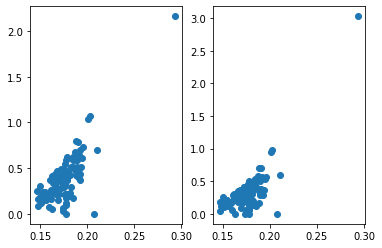

In [18]:
norm_odors= np.zeros(odors.shape[:2])
for i in range(odors.shape[0]):
    norm_odors[i,:]= odors[i,:,0]/np.amax(odors[i,:,0])
owidths= np.std(norm_odors,axis=1)
plt.figure()
plt.subplot(1,2,1)
plt.scatter(owidths,mxmono)
plt.subplot(1,2,2)
plt.scatter(owidths,mnmono)
print(owidths)

And the corresponding correlation coefficients are as follows:

In [24]:
mxR= np.corrcoef(owidths,mxmono)[0,1]
mnR= np.corrcoef(owidths,mnmono)[0,1]
print("R_mx={}, R_mn={}".format(mxR,mnR))

R_mx=0.7748802863049725, R_mn=0.7829399652563259


Do some diagnostics and diagnostic plots
---

[ 25 143  35   3  26  69  15 126   5  46 145 131 150 121 138 122 139  33
  13 141  63 150  10  35   9  48  33  64 126  37   2 117 132 151  14 150
  17  24 139 141   6 141  14 141 150  90  98  95  14  42  52  26 121  69
  39 122 114 141 122 139  32 144 111 139  48  43 143  86  28  33  61  95
  65  11  50   6  85 118  36  98  92   6 111  54 152 131  85  25  12 143
  35  28  24  82 137 148  86   6  13 128]
(100, 160, 2)


<ipython-input-9-80fa12da49f1>:30: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.reshape(np.log(odors[:,:,0]),(nodor,160)),interpolation="None")


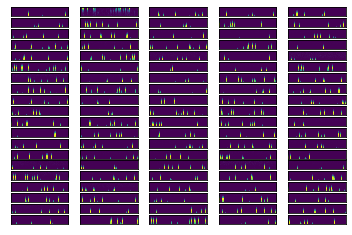

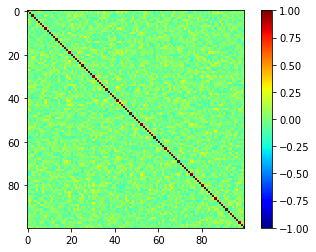

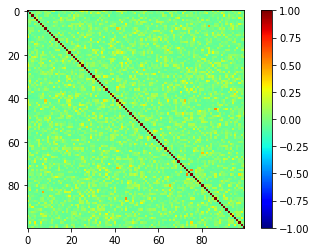

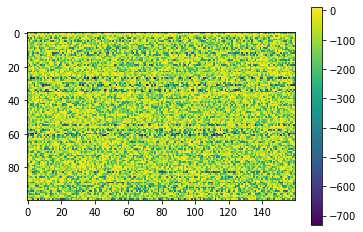

In [9]:
nodor= wds
fig, ax= plt.subplots(20,5)
for i in range(20):
    for j in range(5):
        n= i*5+j
        if n < wds:
            ax[i,j].imshow(np.reshape(amnsdf[n,:,:],(cnum,160)),interpolation="None")
            ax[i,j].set_yticks([])
            ax[i,j].set_xticks([])
print(mxid)
cca= np.zeros((nodor,nodor))
for i in range(nodor):
    for j in range(nodor):
        cc= np.corrcoef(np.reshape(amnsdf[i,-1,:],160),np.reshape(amnsdf[j,-1,:],160))
        cca[i,j]= cc[0,1]
plt.figure()
plt.imshow(cca,cmap="jet", vmin= -1, vmax=1,interpolation="None")
plt.colorbar()
print(odors.shape)
for i in range(nodor):
    for j in range(nodor):
        cc= np.corrcoef(np.reshape(odors[i,:,0],160),np.reshape(odors[j,:,0],160))
        cca[i,j]= cc[0,1]
plt.figure()
plt.imshow(cca,cmap="jet", vmin= -1, vmax=1,interpolation="None")
plt.colorbar()

plt.figure()
plt.imshow(np.reshape(np.log(odors[:,:,0]),(nodor,160)),interpolation="None")
plt.colorbar()

Make line plots of the max and mean responses as a function of concentration
---

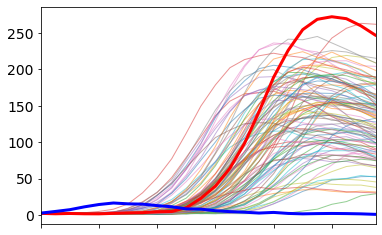

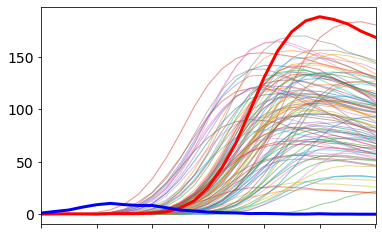

In [10]:
plt.rc('font', size=14) #controls default text size
plt.figure()
td= np.transpose(mxsdfs)
if wds > 2:
    plt.plot(td[:,2:],lw=1,alpha=0.5)
plt.plot(td[:,0],'r',lw=3)
plt.plot(td[:,1],'b',lw=3)
ax= plt.gca()
ax.set_xticks(range(0,cnum,4))
ax.set_xticklabels([])
ax.set_xlim((0,23))
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
#plt.yscale("log")
#ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*0.8)
plt.savefig("max_sdfs.png",dpi=300)
plt.figure()
td= np.transpose(mnsdfs)
if wds > 2:
    plt.plot(td[:,2:],lw=1.0,alpha=0.5)
plt.plot(td[:,0],'r',lw=3)
plt.plot(td[:,1],'b',lw=3)
ax= plt.gca()
ax.set_xlim((0,24))
ax.set_xticks(range(0,cnum,4))
ax.set_xticklabels([])
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
#plt.yscale("log")
#ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*0.8)
plt.savefig("mean_sdfs.png",dpi=300)

Display Responses to binary mixtures of the "geosmin odor" and the "IAA odor"
--

In [11]:
li= 0
mwds= int(mt_total//batch_t) # corresponds to number of odours presented / number of batches
mmxsdfs= np.zeros((mwds,cnum))
mmnsdfs= np.zeros((mwds,cnum))
aimn= np.zeros((mwds,cnum,nglo))
for i in range(mwds):
    for j in range(cnum):
        left= i*batch_t+j*trial_time
        right= left+trial_time
        while li < len(mspike_t) and mspike_t[li] < left:
            li+= 1
        ri= li
        while ri < len(mspike_t) and mspike_t[ri] < right:
            ri+= 1
        lsdfs= make_sdf(mspike_t[li:ri], mspike_ID[li:ri], np.arange(0,N), left-3*sigma_sdf, right+3*sigma_sdf, dt_sdf, sigma_sdf)
        gsdfs=glo_avg(lsdfs,5)
        aimn[i,j,:]= np.reshape(np.mean(gsdfs[3000:6000,:],axis=0),(1,1,-1))
        mmxsdfs[i,j]= np.amax(np.amax(gsdfs))
        mmnsdfs[i,j]= np.amax(np.mean(gsdfs[3000:6000,:],axis=0))

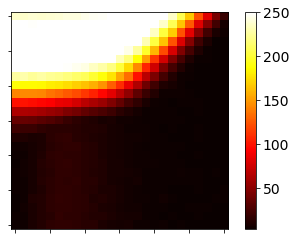

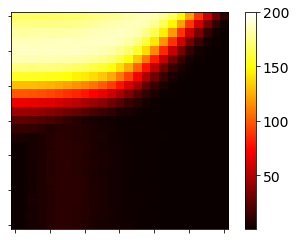

In [12]:
plt.figure()
plt.imshow(mmxsdfs,cmap="hot",vmax=250,interpolation="None")
ax= plt.gca()
ax.invert_yaxis()
ax.set_xticks(range(0,cnum,4))
ax.set_xticklabels([])
ax.set_yticks(range(0,cnum,4))
ax.set_yticklabels([])
plt.colorbar()
plt.savefig("mix_max_map.png",dpi=300)
plt.figure()
plt.imshow(mmnsdfs,cmap="hot",vmax=200,interpolation="None")
ax= plt.gca()
ax.invert_yaxis()
ax.set_xticks(range(0,cnum,4))
ax.set_xticklabels([])
ax.set_yticks(range(0,cnum,4))
ax.set_yticklabels([])
plt.colorbar()
plt.savefig("mix_mean_map.png",dpi=300)

Investigate how much the PN response patterns correlate with the OR response patterns for "Geosmin" and "IAA"
---

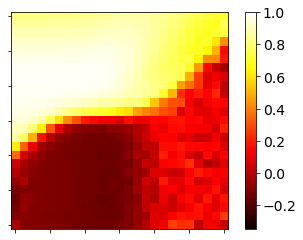

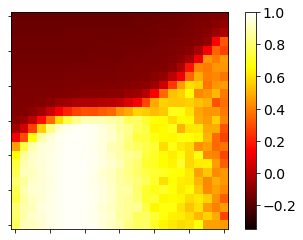

In [13]:
odors= np.load(label+"_odors.npy")
o1= 0
o2= 1
c= np.zeros((cnum,cnum))
for o in [o1, o2]:
    for i in range(cnum):
        for j in range(cnum):
            c[i,j]= np.corrcoef(np.reshape(aimn[i,j,:],-1),np.reshape(odors[o,:,0],-1))[0,1]

    plt.figure()
    plt.imshow(c,cmap="hot",vmin=-0.35, vmax= 1.0,interpolation="None")
    plt.gca().invert_yaxis()
    plt.colorbar()
    ax= plt.gca()
    ax.set_xticks(range(0,cnum,4))
    ax.set_xticklabels([])
    ax.set_yticks(range(0,cnum,4))
    ax.set_yticklabels([])
    plt.savefig("odor_"+str(o)+"_correl.png", dpi=300)